In [1]:
import os
import sys
import math
import utils
import random
import layers
import dataset
import binvox_rw
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D

# tf.contrib.eager.enable_eager_execution() 

# place holders
x=tf.placeholder(tf.float32,[None,24,137,137,3]) 
y=tf.placeholder(tf.float32,[None,32,32,32])

# encoder network
cur_tensor=x
encoder_outputs=[cur_tensor]
print(cur_tensor.shape)
k_s = [3,3]
conv_filter_count = [96, 128, 256, 256, 256, 256]
for i in range(6): 
    ks=[7,7]if i is 0 else k_s  
    with tf.name_scope("encoding_block"): 
        cur_tensor=tf.map_fn(lambda a:tf.layers.conv2d(a,filters=conv_filter_count[i],padding='SAME',kernel_size= k_s,activation=None),cur_tensor)
        cur_tensor=tf.map_fn(lambda a:tf.layers.max_pooling2d(a,2,2),cur_tensor)
        cur_tensor=tf.map_fn(tf.nn.relu,cur_tensor)
        print(cur_tensor.shape)
        encoder_outputs.append(cur_tensor)

# flatten tensors
cur_tensor=tf.map_fn(tf.contrib.layers.flatten,cur_tensor)
cur_tensor=tf.map_fn(lambda a:tf.contrib.layers.fully_connected(a,1024,activation_fn=None),cur_tensor)
encoder_outputs.append(cur_tensor)
print(cur_tensor.shape)

# recurrent module
with tf.name_scope("recurrent_module"): 
    
    N,n_x,n_h=4,1024,256
   
    recurrent_module=layers.GRU_R2N2(n_cells=N,n_input=n_x,n_hidden_state=n_h);

    # initial hidden state
    hidden_state_list=[]
    with open("net.config") as f:
        batch_size=int(f.readline())
        hidden_state= tf.zeros([batch_size,4,4,4,256])
    
    # feed batches of seqeuences
    for t in range(24):
        fc_batch_t = cur_tensor[:,t,:]
        hidden_state_list.append(hidden_state)
        hidden_state = recurrent_module.call(fc_batch_t, hidden_state)
    print(hidden_state.shape)
cur_tensor=hidden_state


# decoding network
decoder_outputs=[cur_tensor]
cur_tensor=layers.unpool3D(cur_tensor)
print(cur_tensor.shape)
decoder_outputs.append(cur_tensor)

k_s = [3,3,3]
deconv_filter_count = [128, 128, 128, 64, 32, 2]
for i in range(2,4): 
    with tf.name_scope("decoding_block"):
        cur_tensor=tf.layers.conv3d(cur_tensor,padding='SAME',filters=deconv_filter_count[i],kernel_size= k_s,activation=None)
        cur_tensor=layers.unpool3D(cur_tensor)
        cur_tensor=tf.nn.relu(cur_tensor)
        print(cur_tensor.shape)
        decoder_outputs.append(cur_tensor)
            
for i in range(4,6): 
    with tf.name_scope("decoding_block_without_unpooling"):
        cur_tensor=tf.layers.conv3d(cur_tensor,padding='SAME',filters=deconv_filter_count[i],kernel_size= k_s,activation=None)
        cur_tensor=tf.nn.relu(cur_tensor)
        print(cur_tensor.shape)
        decoder_outputs.append(cur_tensor)
        

with tf.name_scope("cost"):
    #3d voxel-wise softmax
    y_hat=tf.nn.softmax(decoder_outputs[-1])
    p=y_hat[:,:,:,:,0]
    q=y_hat[:,:,:,:,1]
    cross_entropies=tf.reduce_sum(-tf.multiply(tf.log(p),y)-tf.multiply(tf.log(q),1-y),[1,2,3])
    loss=tf.reduce_mean(cross_entropies)
    optimizer = tf.train.GradientDescentOptimizer(100).minimize(loss)

(?, 24, 137, 137, 3)
(?, 24, 68, 68, 96)
(?, 24, 34, 34, 128)
(?, 24, 17, 17, 256)
(?, 24, 8, 8, 256)
(?, 24, 4, 4, 256)
(?, 24, 2, 2, 256)
(?, 24, 1024)
(?, 4, 4, 4, 256)
(?, 8, 8, 8, 256)
(?, 16, 16, 16, 128)
(?, 32, 32, 32, 64)
(?, 32, 32, 32, 32)
(?, 32, 32, 32, 2)


In [2]:
# output
os.system("rm -rf out/*")
print("debugging")
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

# setup dataset
shapenet=dataset.ShapeNet()

#read config
with open("net.config") as f:
    shapenet.batch_size=int(f.readline())
    epoch=int(f.readline())
    learning_rate=float(f.readline())


data,label=shapenet.next_train_batch()
fd={x:data, y: label};

# tensorboard
os.system("rm -rf logs/*")
writer = tf.summary.FileWriter("./logs/")
writer.add_graph(sess.graph)

# output dir and setup 
out_root_dir="out/"

debugging


In [3]:
voxel=tf.argmax(y_hat,axis=4)
voxel=tf.cast(voxel,dtype=tf.float32)
out=voxel.eval(fd)
print(out.shape)

(1, 32, 32, 32)


In [4]:
rounded_voxel=tf.round(hidden_state)
out=rounded_voxel.eval(fd)

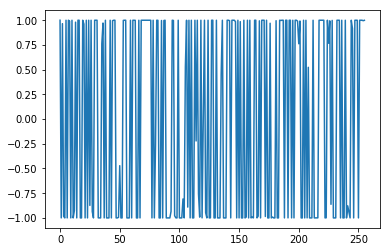

In [8]:
%matplotlib inline
plt.plot(hidden_state[0,3,0,0,:].eval(fd))

In [ ]:
fig=plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(out[0,:,:,:,255],edgecolor='k')
ax.view_init(30, 330)
plt.show()
plt.close()

In [ ]:
item=30
x=data[item]

y=label[item]

utils.imshow_multichannel(x[0])

In [ ]:
batch_size,time_steps,n_layers=1,24,8

# debug loop for a single input in a batch
for b in range(batch_size):
    batch_dir=os.path.join(out_root_dir,"batch_{}".format(b))
    os.makedirs(batch_dir) if not os.path.isdir(batch_dir) else print("dir exists")
      
#     # encoding layers
#     for l in range(n_layers):
#         out_dir=os.path.join(batch_dir,"encoding_layer_{}".format(l))
#         pass if os.path.isdir(out_dir) else os.makedirs(out_dir)
#         for t in range(time_steps):
#             if l<7:
#                 var=encoder_outputs[l][b,t]
#                 utils.imsave_multichannel(var.eval(fd),out_dir+"/time_{}.png".format(t))
#             else:
#                 var=encoder_outputs[l][b,t].eval(fd)
#                 plt.figure()
#                 plt.plot(var)
#                 plt.savefig(out_dir+"/time_{}.png".format(t))    
        
    # recurrent module
    out_dir=os.path.join(batch_dir,"recurrent_module")
    os.makedirs(out_dir) if not os.path.isdir(out_dir) else print("dir exists")
    for t in range(1):    
        val=hidden_state_list[t].eval(fd)
        print(val.shape)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        val=np.random.randint(0,2,size=[3,3,3])
        print(val.shape)
        
        print(label.shape)
        ax.voxels(label[0],edgecolor='k')

        plt.show()
        plt.close()
       

In [ ]:
 for i in range(4):
            for j in range(4):
                for k in range(4):
                    cell_hidden_state=grid_hidden_state[i,j,k] 
                    plt.figure()
                    plt.plot(cell_hidden_state)
                    plt.savefig(os.path.join(cur_dir,'cell_{}{}{}_at_{}.png'.format(i,j,k,t)))
                    plt.close()

In [ ]:
decoder_dir="out/decoder"
# debug decoder net
voxel=tf.argmax(y_hat,axis=4)
voxel=tf.cast(voxel,dtype=tf.float32)

out=voxel.eval(fd)
outvoxel=binvox_rw.Voxels(out,out.shape,[0,0,0],1,'xzy')
with open("out/voxels/{}.binvox".format(),'w') as f:
    outvoxel.write(f)

In [ ]:
# matplot 3d plot setup
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

In [ ]:
%matplotlib inline
feature_vectors=encoder_outputs[7].eval(fd)
plt.figure()
f, axarr = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        t=i*5+j
        if(t<24):
            p=feature_vectors[0,t]
            axarr[i, j].plot(p)

In [ ]:
import seaborn as sns

In [ ]:
s_input=stacked_input.eval(fd)
print(s_input.shape)
for i in range(4):
    for j in range(4):
        for k in range(4):
            fc=s_input[i,j,k,0,23]
            plt.figure()
            plt.plot(fc)
            plt.savefig(os.path.join("out",'{}{}{}.png'.format(i,j,k)))
            plt.close() 
            sys.exit()